In [1]:
# Imports and Setup #
import torch
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import logging
import os
from tqdm import tqdm

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Set up paths
DATA_DIR = Path('data')
RAW_DIR = DATA_DIR / 'raw' / 'test-clean'
PROCESSED_DIR = DATA_DIR / 'processed' / 'test-clean'

# Create directories if they don't exist
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
(PROCESSED_DIR / 'spectrograms').mkdir(exist_ok=True)
(PROCESSED_DIR / 'waveforms').mkdir(exist_ok=True)

In [2]:
# Processing Functions
def process_audio_file(audio_path, sample_rate=16000):
    """Process a single audio file."""
    try:
        # Load audio
        waveform, sr = torchaudio.load(audio_path)
        
        # Resample if necessary
        if sr != sample_rate:
            resampler = torchaudio.transforms.Resample(sr, sample_rate)
            waveform = resampler(waveform)
        
        # Convert to mel spectrogram
        mel_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=1024,
            hop_length=256,
            n_mels=80
        )
        mel_spec = mel_transform(waveform)
        
        return waveform, mel_spec, True
        
    except Exception as e:
        logger.error(f"Error processing {audio_path}: {str(e)}")
        return None, None, False

def plot_audio(waveform, mel_spec, title=""):
    """Plot waveform and spectrogram."""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # Plot waveform
    waveform_np = waveform[0].detach().cpu().numpy()  # Convert to numpy array
    ax1.plot(waveform_np)
    ax1.set_title(f"{title} - Waveform")
    ax1.set_xlabel("Sample")
    ax1.set_ylabel("Amplitude")
    
    # Plot spectrogram
    mel_spec_np = mel_spec[0].detach().cpu().numpy()  # Convert to numpy array
    ax2.imshow(np.log2(mel_spec_np), aspect='auto', origin='lower')
    ax2.set_title(f"{title} - Mel Spectrogram")
    ax2.set_xlabel("Frame")
    ax2.set_ylabel("Frequency Bin")
    plt.colorbar(ax2.images[0], ax=ax2, format='%+2.0f dB')
    
    plt.tight_layout()
    plt.show()

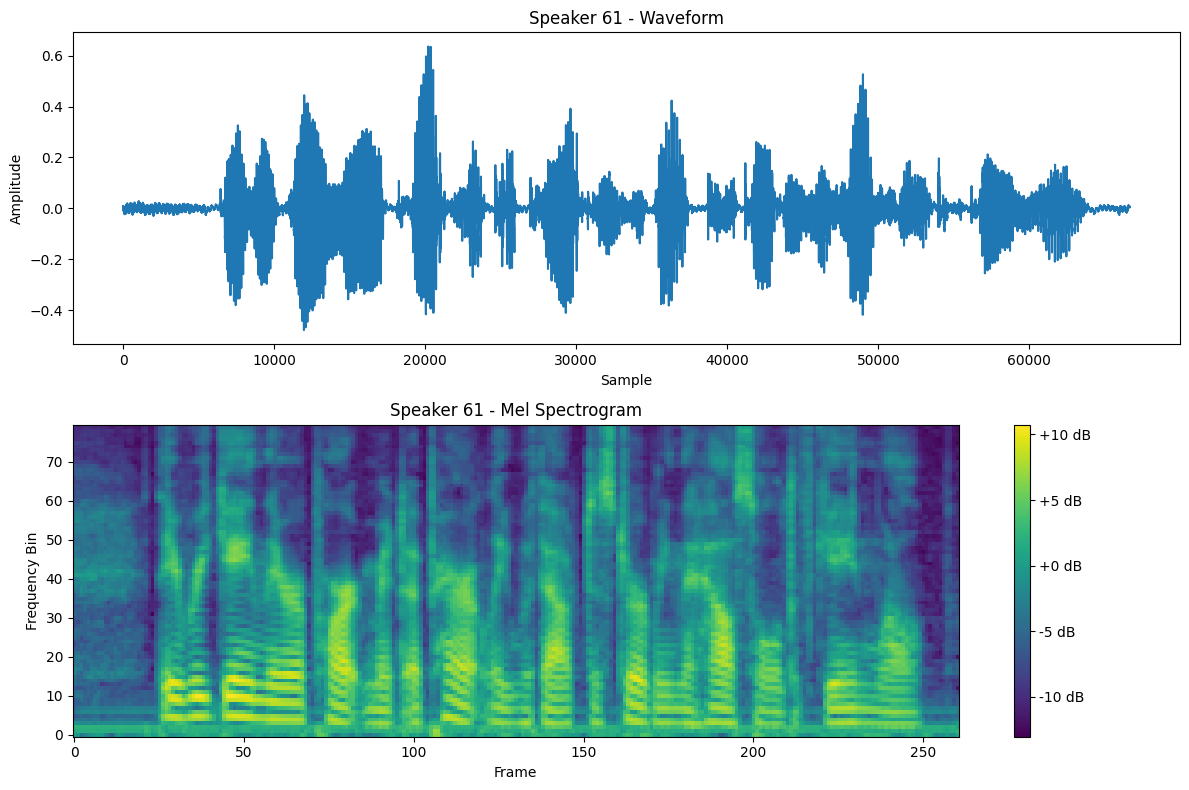

Sample rate: 16000 Hz
Waveform shape: torch.Size([1, 66640])
Mel spectrogram shape: torch.Size([1, 80, 261])


In [3]:
# Process and Visualize a Sample
# Get the first FLAC file (nested in speaker/chapter directories)
audio_files = list(RAW_DIR.glob('**/*.flac'))
if audio_files:
    audio_path = audio_files[0]
    speaker_id = audio_path.parent.parent.name  # Get speaker ID from grandparent directory
    
    # Process the file
    waveform, mel_spec, success = process_audio_file(audio_path)
    
    if success:
        # Plot the results
        plot_audio(waveform, mel_spec, f"Speaker {speaker_id}")
        
        # Print some information
        print(f"Sample rate: {16000} Hz")
        print(f"Waveform shape: {waveform.shape}")
        print(f"Mel spectrogram shape: {mel_spec.shape}")
    else:
        print("Failed to process audio file")
else:
    print("No FLAC files found in the directory")

In [4]:
# Process Entire Dataset
def process_dataset():
    """Process all audio files in the dataset."""
    logger.info("Starting dataset processing...")
    
    # Get all audio files (recursively)
    audio_files = list(RAW_DIR.glob('**/*.flac'))
    logger.info(f"Found {len(audio_files)} audio files to process")
    
    # Process each file
    success_count = 0
    for audio_path in tqdm(audio_files):
        # Extract speaker ID from path
        speaker_id = audio_path.parent.parent.name
        
        # Process the file
        waveform, mel_spec, success = process_audio_file(audio_path)
        
        if success:
            # Save processed files
            base_name = f"{speaker_id}_{audio_path.stem}"
            
            # Save mel spectrogram
            spec_path = PROCESSED_DIR / 'spectrograms' / f"{base_name}_mel.pt"
            torch.save(mel_spec, spec_path)
            
            # Save waveform
            wave_path = PROCESSED_DIR / 'waveforms' / f"{base_name}_wave.pt"
            torch.save(waveform, wave_path)
            
            success_count += 1
    
    logger.info(f"Processing complete. Successfully processed {success_count}/{len(audio_files)} files")

# Run the processing
process_dataset()

INFO:__main__:Starting dataset processing...
INFO:__main__:Found 2620 audio files to process
100%|██████████| 2620/2620 [00:12<00:00, 211.64it/s]
INFO:__main__:Processing complete. Successfully processed 2620/2620 files


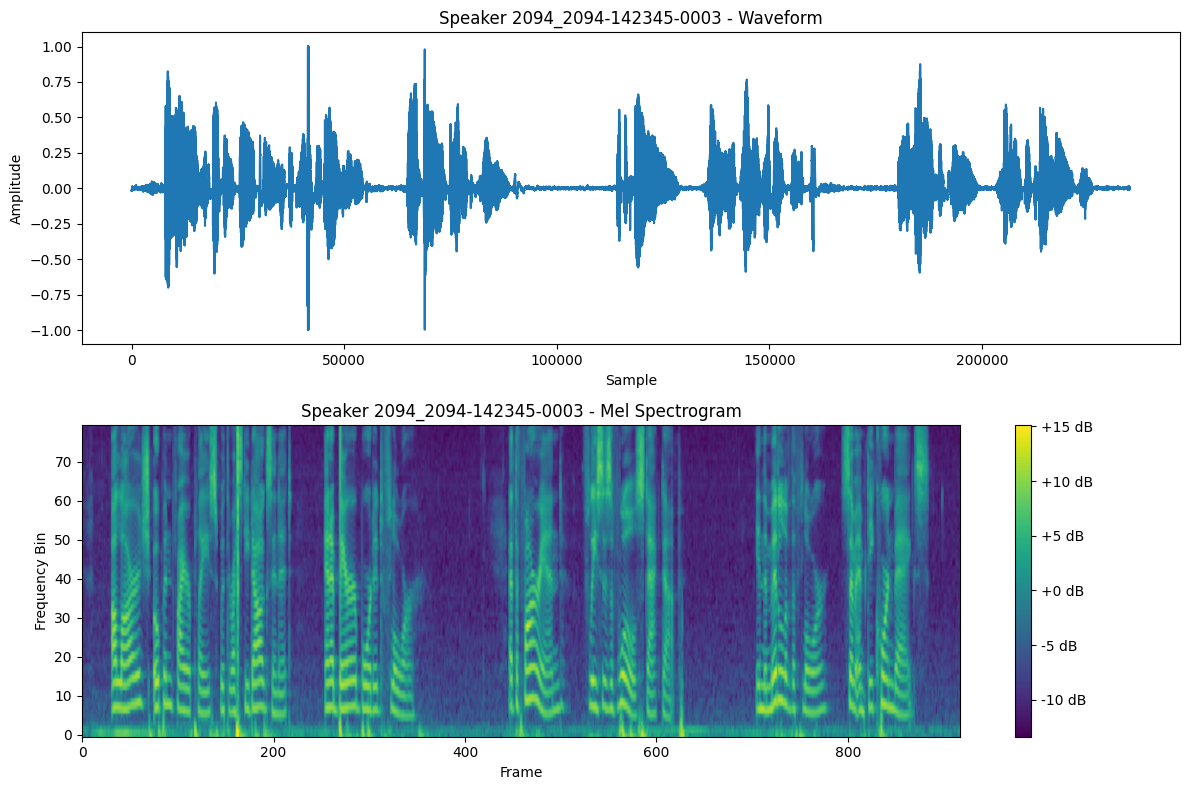

/var/folders/qn/wjd_1yzj2qlf6mcprg5pgjpc0000gn/T/ipykernel_96477/511628632.py:41: RuntimeWarning: divide by zero encountered in log2
  ax2.imshow(np.log2(mel_spec_np), aspect='auto', origin='lower')


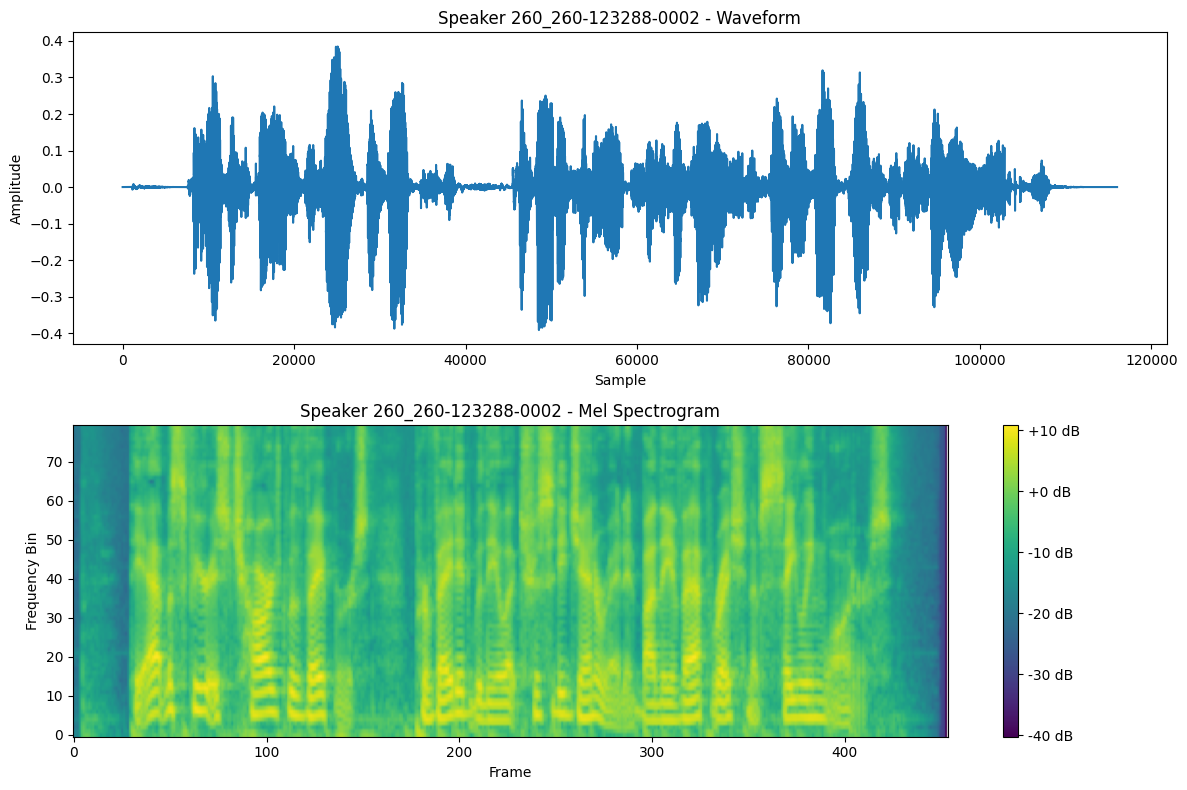

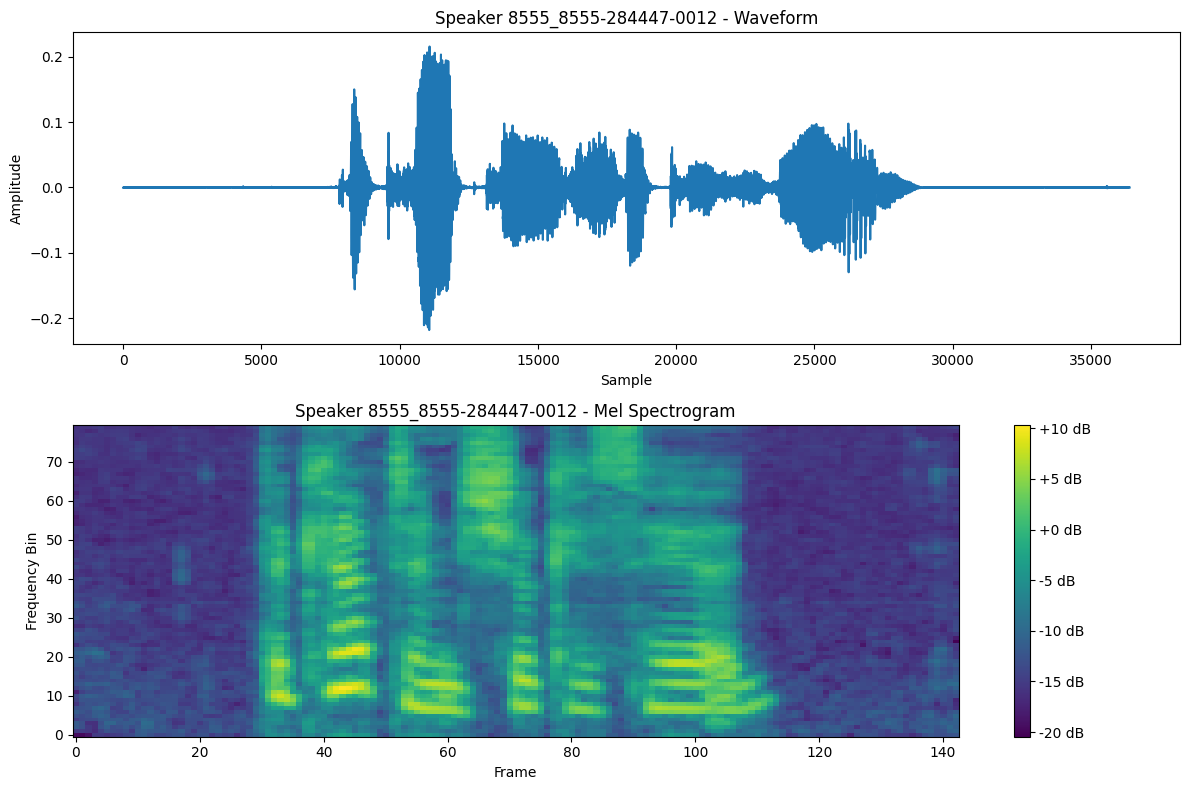

Total spectrogram files: 2620
Total waveform files: 2620

Spectrogram Shapes (should be consistent):
  torch.Size([1, 80, 385])
  torch.Size([1, 80, 268])
  torch.Size([1, 80, 289])
  torch.Size([1, 80, 140])
  torch.Size([1, 80, 170])
  torch.Size([1, 80, 162])
  torch.Size([1, 80, 225])
  torch.Size([1, 80, 948])
  torch.Size([1, 80, 534])
  torch.Size([1, 80, 167])

Spectrogram Statistics (should be in reasonable ranges):
  Sample 1: Min=0.00, Max=2619.44, Mean=10.70, Std=79.99
  Sample 2: Min=0.00, Max=5156.11, Mean=7.47, Std=78.94
  Sample 3: Min=0.00, Max=2582.28, Mean=7.53, Std=66.44
  Sample 4: Min=0.00, Max=1252.48, Mean=4.83, Std=36.97
  Sample 5: Min=0.00, Max=941.45, Mean=3.92, Std=23.52
  Sample 6: Min=0.00, Max=6088.46, Mean=16.57, Std=138.47
  Sample 7: Min=0.00, Max=734.99, Mean=1.47, Std=10.77
  Sample 8: Min=0.00, Max=3354.49, Mean=5.62, Std=52.05
  Sample 9: Min=0.00, Max=2909.89, Mean=12.58, Std=89.15
  Sample 10: Min=0.00, Max=656.09, Mean=2.39, Std=18.45

Waveform

In [11]:
# Visualize Processed Data
def visualize_processed_samples(num_samples=5):
    """
    Visualize a few processed samples to verify the quality of the processing.
    
    Parameters:
    - num_samples: Number of samples to visualize
    """
    # Get a list of processed mel spectrograms
    spec_files = list((PROCESSED_DIR / 'spectrograms').glob('*.pt'))

    if not spec_files:
        logger.warning("No processed files found.")
        return
    
    # Select a few random samples
    import random
    samples = random.sample(spec_files, min(num_samples, len(spec_files)))

    for spec_path in samples:
        # Get speaker ID and filename from the path
        base_name = spec_path.stem.replace('_mel','')

        # Load corresponding waveform
        wave_path = PROCESSED_DIR / 'waveforms' / f"{base_name}_wave.pt"

        if wave_path.exists():
            # Load the files
            mel_spec = torch.load(spec_path)
            waveform = torch.load(wave_path)

            # Visualize 
            plot_audio(waveform, mel_spec, f"Speaker {base_name}")
        else: 
            logger.warning(f"Waveform file not found for {base_name}")

visualize_processed_samples(3)  

def check_processed_data_statistics():
    """Check basic statistics of processed data to ensure quality."""
    import random  # Add this import
    
    spec_files = list((PROCESSED_DIR / 'spectrograms').glob('*.pt'))
    wave_files = list((PROCESSED_DIR / 'waveforms').glob('*.pt'))
    
    print(f"Total spectrogram files: {len(spec_files)}")
    print(f"Total waveform files: {len(wave_files)}")
    
    if not spec_files:
        print("No processed files found!")
        return
    
    # Check a sample of files for proper dimensions and values
    num_samples = min(10, len(spec_files))
    sample_specs = random.sample(spec_files, num_samples)
    
    spec_shapes = []
    spec_stats = []
    wave_stats = []
    
    for spec_path in sample_specs:
        base_name = spec_path.stem.replace('_mel', '')
        wave_path = PROCESSED_DIR / 'waveforms' / f"{base_name}_wave.pt"
        
        if wave_path.exists():
            mel_spec = torch.load(spec_path)
            waveform = torch.load(wave_path)
            
            spec_shapes.append(mel_spec.shape)
            spec_stats.append({
                'min': float(mel_spec.min()),
                'max': float(mel_spec.max()),
                'mean': float(mel_spec.mean()),
                'std': float(mel_spec.std())
            })
            
            wave_stats.append({
                'min': float(waveform.min()),
                'max': float(waveform.max()),
                'mean': float(waveform.mean()),
                'std': float(waveform.std()),
                'duration': waveform.shape[1] / 16000  # Assuming 16kHz sample rate
            })
    
    print("\nSpectrogram Shapes (should be consistent):")
    for shape in spec_shapes:
        print(f"  {shape}")
    
    print("\nSpectrogram Statistics (should be in reasonable ranges):")
    for i, stats in enumerate(spec_stats):
        print(f"  Sample {i+1}: Min={stats['min']:.2f}, Max={stats['max']:.2f}, Mean={stats['mean']:.2f}, Std={stats['std']:.2f}")
    
    print("\nWaveform Statistics:")
    for i, stats in enumerate(wave_stats):
        print(f"  Sample {i+1}: Min={stats['min']:.2f}, Max={stats['max']:.2f}, Mean={stats['mean']:.2f}, Duration={stats['duration']:.2f}s")

# Run the check
check_processed_data_statistics()

